# Data preparation

In [3]:
import sys
sys.path.append('..')

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from utils import utils, cross_validation

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)
nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17)

### Prediction

In [4]:
import pandas as pd
import numpy as np
import sklearn.linear_model as skl_lm
import matplotlib.pyplot as plt
import statsmodels as sm
import matplotlib.pyplot as plt
from utils import utils
from statsmodels.tsa.statespace.sarimax import SARIMAX

n = len(nh3)
rmse = []
k = 18
p = 2
q = 2
d = 0

for i in range(k - 1):
    start = ((n * (i + 1)) / k )

    # Divide data into two dataset: training and validation
    train_set = nh3[0:int(start)].to_period('M')
    validation_set = nh3[int(start):int(start+int(n/k))].to_period('M')

    # Model fitting
    #model = sm.tsa.arima.model.ARIMA(train_set, order=(p,d,q))
    model = SARIMAX(train_set, order=(p,d,q))
    model_fit = model.fit()

    predictions = []
    errors = []

    # Predictions
    for i in range(int(n/k)):
        prediction = model_fit.forecast()
        model_fit = model_fit.append([prediction.values[0]])
        predictions.append(prediction.values[0])
        errors.append(validation_set.values[i] - prediction.values[0])
    rmse.append(sum(np.array(errors)**2))

errors_ts = pd.Series(np.array(errors), index=validation_set.index)



C:\Users\fabio\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\fabio\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\fabio\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\fabio\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

# Residuals analysis

## Plots

<AxesSubplot:xlabel='time'>

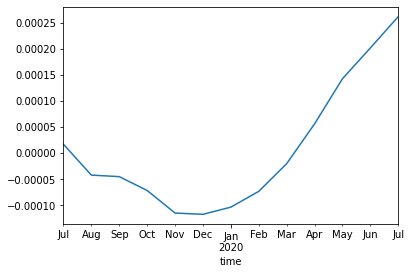

In [5]:
errors_ts.plot()

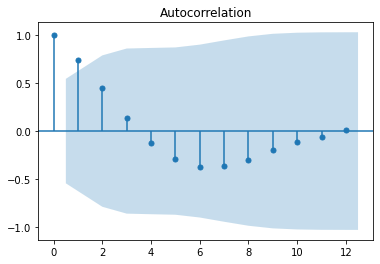

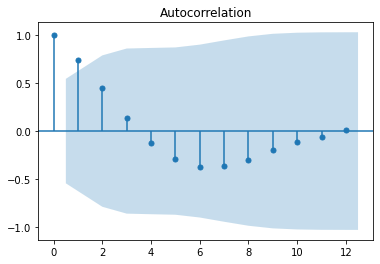

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(errors_ts)

## Autocorrelation

Ljung-box test

Checks if residuals are white noise:
* Accept H0 = no autocorrelations between the series and its first `lags` lags
* Reject H0 = autocorrelations between the series and its first `lags` lags

In [7]:
from statsmodels.stats.diagnostic import acorr_ljungbox
model_df = p+d+q # degrees of freedom of the model
lbvalue, pvalue = acorr_ljungbox(errors_ts, lags=12, model_df=model_df)
pvalue

array([           nan,            nan,            nan,            nan,
       9.36250638e-05, 7.15086371e-05, 3.16766095e-05, 1.89537194e-05,
       2.33079280e-05, 4.16662437e-05, 8.77990755e-05, 1.93046411e-04])

In [8]:
alpha = 0.05
[i < alpha for i in pvalue]

[False, False, False, False, True, True, True, True, True, True, True, True]

## Normality

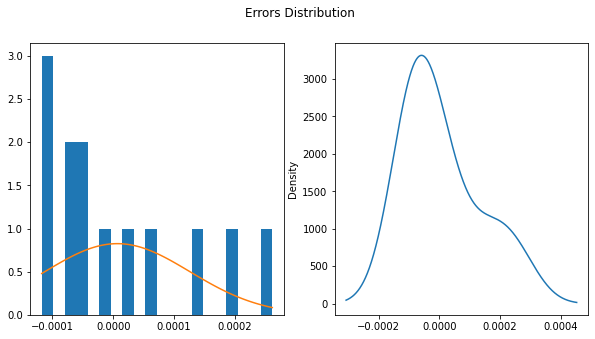

jarque bera test: normally distributed, pvalue: 0.38186378978890395


NameError: name 'lilliefors' is not defined

In [10]:
from utils.plots import plot_distributions
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import lilliefors


plot_distributions(errors_ts, 'Errors Distribution')

jb, pvalue, sk, k = jarque_bera(errors_ts)
print('jarque bera test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

ksstat, pvalue = lilliefors(errors_ts)
print('lilliefors test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))